In [8]:
import os
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, ResNet50, VGG16, EfficientNetB0
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [9]:
round3_base_path = r'C:\Users\gajje\OneDrive\Desktop\Major\Lung_diagnosis_files\Dataset\Dataset\Dataset\round-3'
percent_folder = '75'

base_percent_path = os.path.join(round3_base_path, percent_folder)
level1_path = os.path.join(base_percent_path, 'Level1', '10%Base')
level2_path = os.path.join(base_percent_path, 'Level2', 'Inbox')
level3_path = os.path.join(base_percent_path, 'Level3', 'Outbox')
training_root = os.path.join(base_percent_path, 'Training')

training_subfolders = ['90%Base', 'Th1', 'Th2', 'Th3']
training_paths = [os.path.join(training_root, sub) for sub in training_subfolders]

# Target folders
r3_train_dir = f'round3_{percent_folder}/train'
r3_test1_dir = f'round3_{percent_folder}/test1'
r3_test2_dir = f'round3_{percent_folder}/test2'
r3_test3_dir = f'round3_{percent_folder}/test3'

for folder in [r3_train_dir, r3_test1_dir, r3_test2_dir, r3_test3_dir]:
    shutil.rmtree(folder, ignore_errors=True)
    os.makedirs(folder, exist_ok=True)

def split_and_copy(src_folder, dst_folder):
    labels = os.listdir(src_folder)
    for label in labels:
        src_label_path = os.path.join(src_folder, label)
        dst_label_path = os.path.join(dst_folder, label)
        os.makedirs(dst_label_path, exist_ok=True)
        files = [f for f in os.listdir(src_label_path)
                 if os.path.isfile(os.path.join(src_label_path, f)) and f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        for f in files:
            shutil.copy(os.path.join(src_label_path, f), os.path.join(dst_label_path, f))

# Prepare train and test datasets
for path in training_paths:
    split_and_copy(path, r3_train_dir)
split_and_copy(level1_path, r3_test1_dir)
split_and_copy(level2_path, r3_test2_dir)
split_and_copy(level3_path, r3_test3_dir)


In [10]:
img_size = (128, 128)
batch_size = 16
datagen = ImageDataGenerator(rescale=1./255)

train_data = datagen.flow_from_directory(r3_train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
test1_data = datagen.flow_from_directory(r3_test1_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)
test2_data = datagen.flow_from_directory(r3_test2_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)
test3_data = datagen.flow_from_directory(r3_test3_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)

class_names = list(train_data.class_indices.keys())
num_classes = len(class_names)


Found 1497 images belonging to 3 classes.
Found 157 images belonging to 3 classes.
Found 534 images belonging to 3 classes.
Found 648 images belonging to 3 classes.


In [11]:
def build_custom_cnn():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

def build_transfer_model(base_model_fn):
    base = base_model_fn(weights='imagenet', include_top=False, input_shape=(128,128,3))
    base.trainable = False
    model = Sequential([
        base,
        Flatten(),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

def build_alexnet():
    model = Sequential([
        Conv2D(96, (11,11), strides=(4,4), activation='relu', input_shape=(128,128,3)),
        MaxPooling2D(pool_size=(3,3), strides=(2,2)),
        Conv2D(256, (5,5), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(3,3), strides=(2,2)),
        Conv2D(384, (3,3), padding='same', activation='relu'),
        Conv2D(384, (3,3), padding='same', activation='relu'),
        Conv2D(256, (3,3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(3,3), strides=(2,2)),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model


In [12]:
def evaluate_model(model, test_data, level_name):
    y_true = test_data.classes
    y_pred = np.argmax(model.predict(test_data), axis=1)

    print(f"\n Classification Report for {level_name}:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.title(f"Confusion Matrix - {level_name}")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return model.evaluate(test_data, verbose=0)[1]  # accuracy

def train_and_evaluate(model, model_name):
    print(f"\n Training Model: {model_name}")
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(train_data, epochs=10, validation_data=test1_data, verbose=1)

    accs = []
    for data, level in zip([test1_data, test2_data, test3_data], ['Level 1', 'Level 2', 'Level 3']):
        acc = evaluate_model(model, data, level)
        accs.append(acc)

    avg_acc = np.mean(accs)
    print(f"\n {model_name} - Average Accuracy Across Levels: {avg_acc:.4f}")
    return model_name, accs, avg_acc


C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



 Training Model: Custom CNN
Epoch 1/10


C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - accuracy: 0.3673 - loss: 1.7522 - val_accuracy: 0.6943 - val_loss: 0.8642
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - accuracy: 0.6702 - loss: 0.7596 - val_accuracy: 0.7580 - val_loss: 0.4535
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 154ms/step - accuracy: 0.8296 - loss: 0.3769 - val_accuracy: 0.8726 - val_loss: 0.2908
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 203ms/step - accuracy: 0.9547 - loss: 0.1381 - val_accuracy: 0.9299 - val_loss: 0.1970
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 194ms/step - accuracy: 0.9837 - loss: 0.0591 - val_accuracy: 0.9363 - val_loss: 0.1629
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 201ms/step - accuracy: 1.0000 - loss: 0.0116 - val_accuracy: 0.9554 - val_loss: 0.1566
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 24s 252ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 0.9618 - val_loss: 0.1155
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 234ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.955

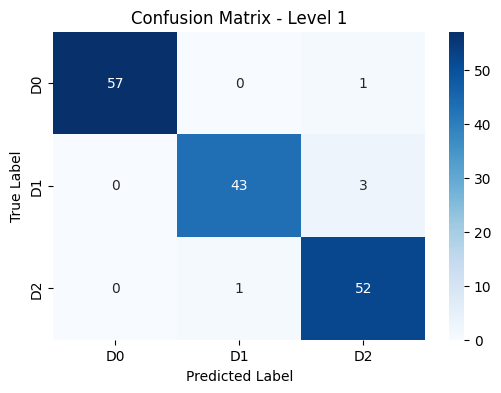

C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step

 Classification Report for Level 2:

              precision    recall  f1-score   support

          D0       0.98      0.99      0.99       174
          D1       0.81      0.91      0.86       180
          D2       0.89      0.78      0.83       180

    accuracy                           0.89       534
   macro avg       0.90      0.89      0.89       534
weighted avg       0.89      0.89      0.89       534



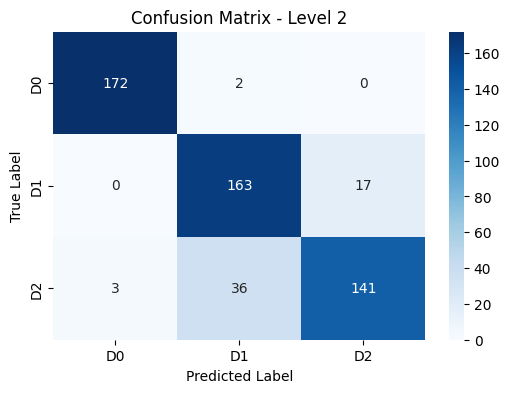

C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step

 Classification Report for Level 3:

              precision    recall  f1-score   support

          D0       1.00      0.97      0.98       252
          D1       0.93      0.85      0.89       144
          D2       0.90      0.96      0.93       252

    accuracy                           0.94       648
   macro avg       0.94      0.93      0.93       648
weighted avg       0.94      0.94      0.94       648



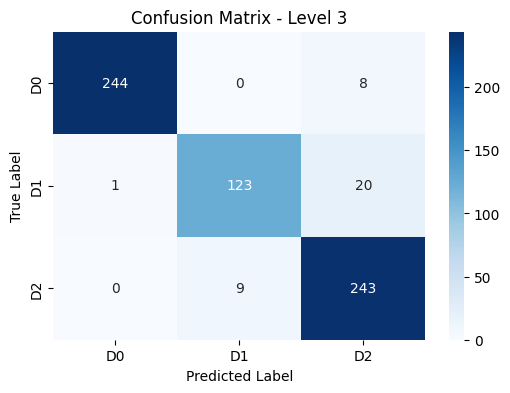


 Custom CNN - Average Accuracy Across Levels: 0.9336

 Training Model: MobileNetV2
Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.4113 - loss: 2.5281 - val_accuracy: 0.5605 - val_loss: 0.9316
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - accuracy: 0.5546 - loss: 0.9047 - val_accuracy: 0.6178 - val_loss: 0.7202
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - accuracy: 0.6276 - loss: 0.8205 - val_accuracy: 0.5478 - val_loss: 0.8766
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - accuracy: 0.6828 - loss: 0.7094 - val_accuracy: 0.5987 - val_loss: 0.7261
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.7270 - loss: 0.6263 - val_accuracy: 0.4650 - val_loss: 1.0800
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - accuracy: 0.7141 - loss: 0.6126 - val_accuracy: 0.6688 - val_loss: 0.7020
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - accuracy: 0.7682 - loss: 0.5478 - val_accuracy: 0.6561 - val_loss: 0.6426
Epoch 8/10
94

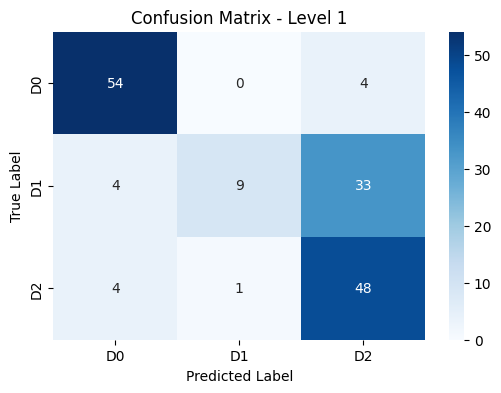

34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step

 Classification Report for Level 2:

              precision    recall  f1-score   support

          D0       0.74      0.72      0.73       174
          D1       0.68      0.16      0.25       180
          D2       0.48      0.87      0.62       180

    accuracy                           0.58       534
   macro avg       0.63      0.58      0.53       534
weighted avg       0.63      0.58      0.53       534



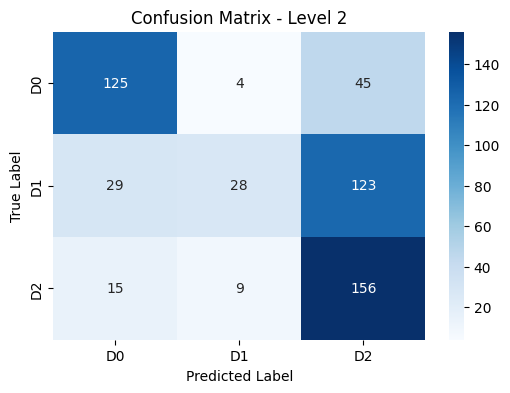

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step

 Classification Report for Level 3:

              precision    recall  f1-score   support

          D0       0.86      0.87      0.86       252
          D1       0.88      0.25      0.39       144
          D2       0.66      0.92      0.77       252

    accuracy                           0.75       648
   macro avg       0.80      0.68      0.67       648
weighted avg       0.79      0.75      0.72       648



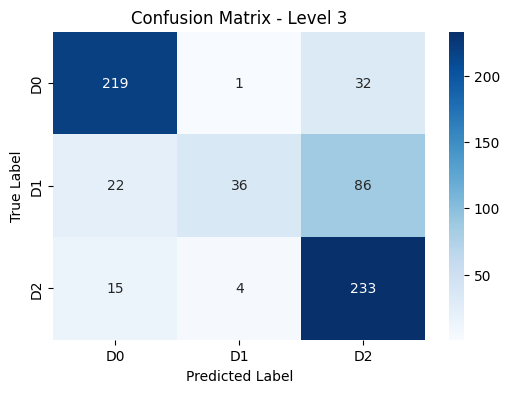


 MobileNetV2 - Average Accuracy Across Levels: 0.6796

 Training Model: ResNet50
Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 40s 350ms/step - accuracy: 0.3432 - loss: 1.1938 - val_accuracy: 0.3376 - val_loss: 1.0974
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 33s 353ms/step - accuracy: 0.3704 - loss: 1.0957 - val_accuracy: 0.3376 - val_loss: 1.0963
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 33s 349ms/step - accuracy: 0.3610 - loss: 1.0940 - val_accuracy: 0.3376 - val_loss: 1.0956
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 36s 380ms/step - accuracy: 0.3858 - loss: 1.0920 - val_accuracy: 0.3376 - val_loss: 1.0955
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 36s 381ms/step - accuracy: 0.3585 - loss: 1.0913 - val_accuracy: 0.3376 - val_loss: 1.0954
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 36s 377ms/step - accuracy: 0.3475 - loss: 1.0937 - val_accuracy: 0.3376 - val_loss: 1.0955
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 31s 329ms/step - accuracy: 0.3710 - loss: 1.0910 - val_accuracy: 0.3376 - val_loss: 1.0957
Epoch 8/10
94/9

C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

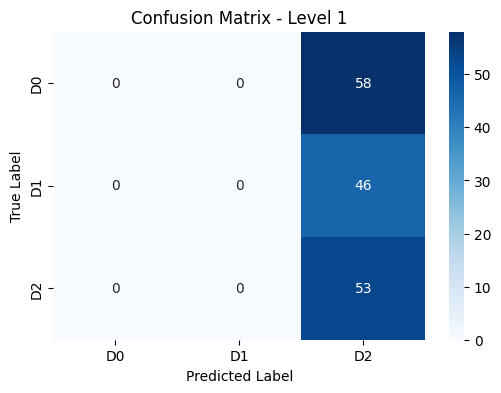

34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 517ms/step

 Classification Report for Level 2:

              precision    recall  f1-score   support

          D0       0.00      0.00      0.00       174
          D1       0.00      0.00      0.00       180
          D2       0.34      1.00      0.50       180

    accuracy                           0.34       534
   macro avg       0.11      0.33      0.17       534
weighted avg       0.11      0.34      0.17       534



C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

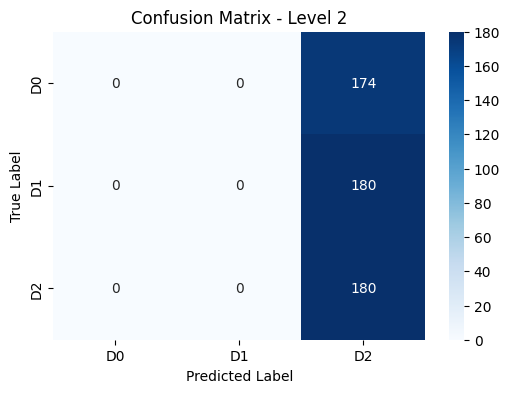

41/41 ━━━━━━━━━━━━━━━━━━━━ 25s 604ms/step

 Classification Report for Level 3:

              precision    recall  f1-score   support

          D0       0.00      0.00      0.00       252
          D1       0.00      0.00      0.00       144
          D2       0.39      1.00      0.56       252

    accuracy                           0.39       648
   macro avg       0.13      0.33      0.19       648
weighted avg       0.15      0.39      0.22       648



C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

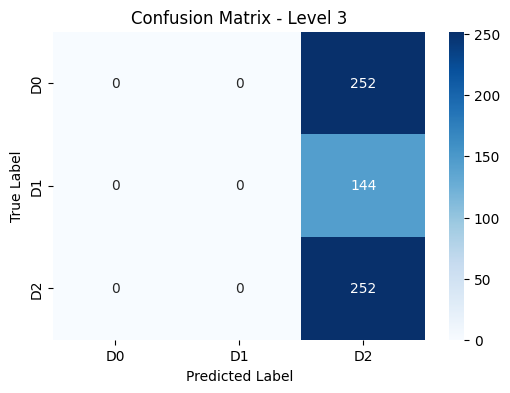


 ResNet50 - Average Accuracy Across Levels: 0.3545

 Training Model: VGG16
Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.3703 - loss: 1.3850 - val_accuracy: 0.3248 - val_loss: 1.1107
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.4496 - loss: 1.0568 - val_accuracy: 0.3503 - val_loss: 1.0463
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 90s 956ms/step - accuracy: 0.5031 - loss: 0.9866 - val_accuracy: 0.4140 - val_loss: 1.0545
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.5034 - loss: 1.0097 - val_accuracy: 0.5096 - val_loss: 0.9303
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 85s 898ms/step - accuracy: 0.6080 - loss: 0.8811 - val_accuracy: 0.6433 - val_loss: 0.8472
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 81s 861ms/step - accuracy: 0.6266 - loss: 0.8384 - val_accuracy: 0.6688 - val_loss: 0.8134
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 83s 884ms/step - accuracy: 0.6445 - loss: 0.8042 - val_accuracy: 0.6624 - val_loss: 0.7930
Epoch 8/10
94/94 ━━━━━━━━━━━

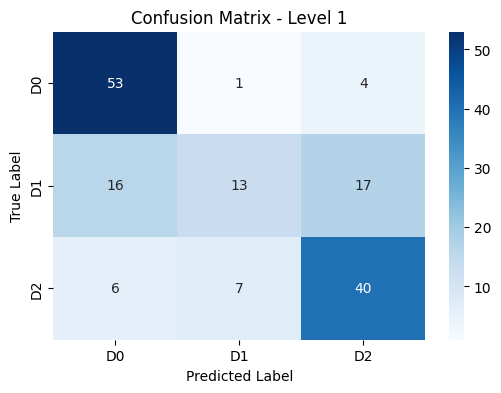

34/34 ━━━━━━━━━━━━━━━━━━━━ 31s 920ms/step

 Classification Report for Level 2:

              precision    recall  f1-score   support

          D0       0.62      0.89      0.73       174
          D1       0.53      0.21      0.30       180
          D2       0.51      0.62      0.56       180

    accuracy                           0.57       534
   macro avg       0.55      0.57      0.53       534
weighted avg       0.55      0.57      0.53       534



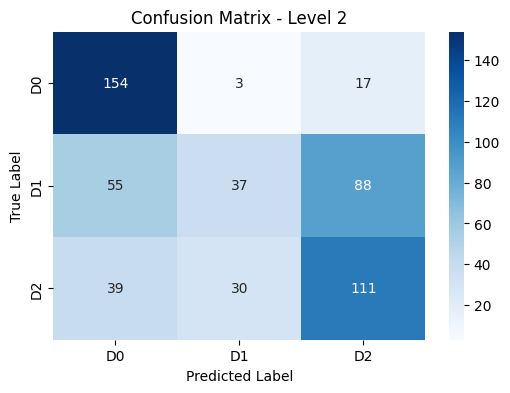

41/41 ━━━━━━━━━━━━━━━━━━━━ 37s 889ms/step

 Classification Report for Level 3:

              precision    recall  f1-score   support

          D0       0.62      0.93      0.75       252
          D1       0.55      0.12      0.19       144
          D2       0.75      0.71      0.73       252

    accuracy                           0.67       648
   macro avg       0.64      0.59      0.56       648
weighted avg       0.65      0.67      0.62       648



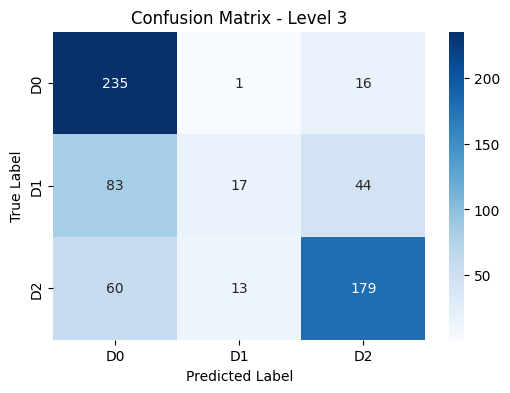


 VGG16 - Average Accuracy Across Levels: 0.6353

 Training Model: EfficientNetB0
Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 46s 338ms/step - accuracy: 0.3149 - loss: 2.4818 - val_accuracy: 0.3376 - val_loss: 1.0986
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 29s 305ms/step - accuracy: 0.3494 - loss: 1.0975 - val_accuracy: 0.3376 - val_loss: 1.0970
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 26s 277ms/step - accuracy: 0.3915 - loss: 1.0948 - val_accuracy: 0.3376 - val_loss: 1.0962
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 176ms/step - accuracy: 0.3751 - loss: 1.0945 - val_accuracy: 0.3376 - val_loss: 1.0956
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 172ms/step - accuracy: 0.3665 - loss: 1.0915 - val_accuracy: 0.3376 - val_loss: 1.0954
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 160ms/step - accuracy: 0.3670 - loss: 1.0893 - val_accuracy: 0.3376 - val_loss: 1.0954
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 195ms/step - accuracy: 0.3864 - loss: 1.0894 - val_accuracy: 0.3376 - val_loss: 1.0954
Epoch 8/10
94/9

C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

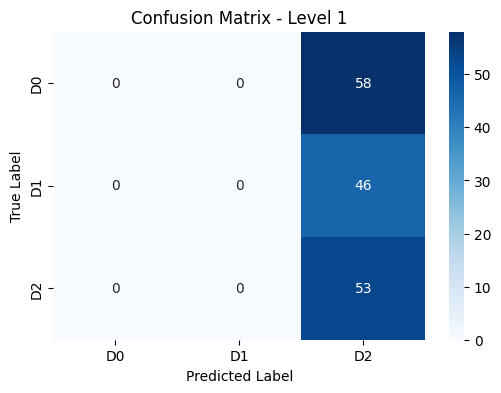

34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step

 Classification Report for Level 2:

              precision    recall  f1-score   support

          D0       0.00      0.00      0.00       174
          D1       0.00      0.00      0.00       180
          D2       0.34      1.00      0.50       180

    accuracy                           0.34       534
   macro avg       0.11      0.33      0.17       534
weighted avg       0.11      0.34      0.17       534



C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

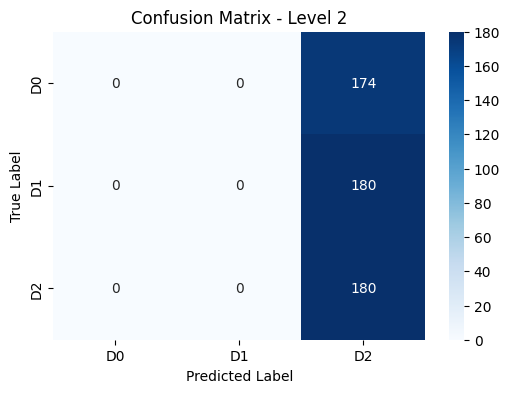

41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step

 Classification Report for Level 3:

              precision    recall  f1-score   support

          D0       0.00      0.00      0.00       252
          D1       0.00      0.00      0.00       144
          D2       0.39      1.00      0.56       252

    accuracy                           0.39       648
   macro avg       0.13      0.33      0.19       648
weighted avg       0.15      0.39      0.22       648



C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

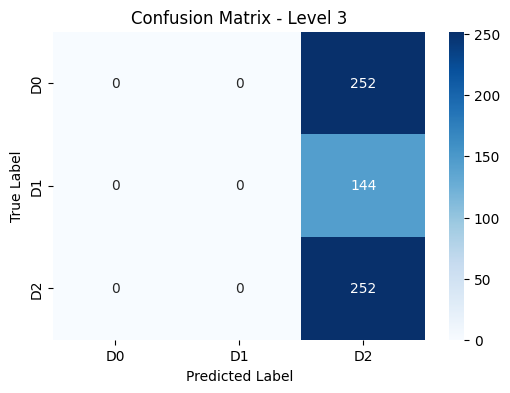


 EfficientNetB0 - Average Accuracy Across Levels: 0.3545

 Training Model: AlexNet
Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 29s 286ms/step - accuracy: 0.3665 - loss: 1.2556 - val_accuracy: 0.3376 - val_loss: 1.0985
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 28s 296ms/step - accuracy: 0.3776 - loss: 1.0895 - val_accuracy: 0.3376 - val_loss: 1.0953
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 26s 278ms/step - accuracy: 0.3451 - loss: 1.0900 - val_accuracy: 0.3376 - val_loss: 1.0964
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 28s 300ms/step - accuracy: 0.3912 - loss: 1.0911 - val_accuracy: 0.3694 - val_loss: 1.0950
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 25s 269ms/step - accuracy: 0.3421 - loss: 1.0917 - val_accuracy: 0.3694 - val_loss: 1.0974
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 25s 260ms/step - accuracy: 0.3479 - loss: 1.0875 - val_accuracy: 0.3376 - val_loss: 1.0974
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 29s 309ms/step - accuracy: 0.3708 - loss: 1.0902 - val_accuracy: 0.3376 - val_loss: 1.0959
Epoch 8/10
94

C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

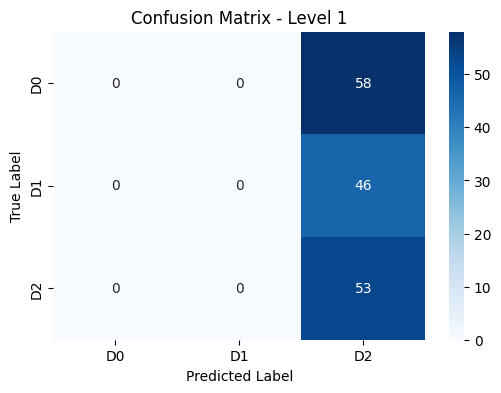

34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step

 Classification Report for Level 2:

              precision    recall  f1-score   support

          D0       0.00      0.00      0.00       174
          D1       0.00      0.00      0.00       180
          D2       0.34      1.00      0.50       180

    accuracy                           0.34       534
   macro avg       0.11      0.33      0.17       534
weighted avg       0.11      0.34      0.17       534



C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

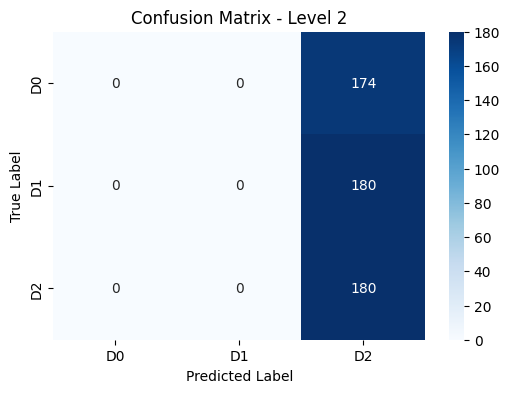

41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step

 Classification Report for Level 3:

              precision    recall  f1-score   support

          D0       0.00      0.00      0.00       252
          D1       0.00      0.00      0.00       144
          D2       0.39      1.00      0.56       252

    accuracy                           0.39       648
   macro avg       0.13      0.33      0.19       648
weighted avg       0.15      0.39      0.22       648



C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

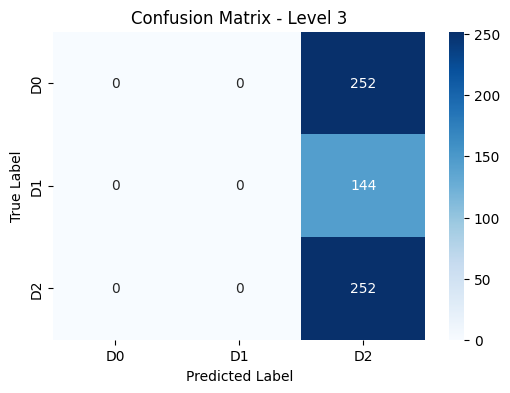


 AlexNet - Average Accuracy Across Levels: 0.3545


In [13]:
results = []

models = {
    "Custom CNN": build_custom_cnn(),
    "MobileNetV2": build_transfer_model(MobileNetV2),
    "ResNet50": build_transfer_model(ResNet50),
    "VGG16": build_transfer_model(VGG16),
    "EfficientNetB0": build_transfer_model(EfficientNetB0),
    "AlexNet": build_alexnet()
}

for name, model in models.items():
    model_name, acc_list, avg_acc = train_and_evaluate(model, name)
    results.append((model_name, acc_list, avg_acc))


In [14]:
# Print Accuracy Results
print("\n\n=== Model Accuracy Summary ===")
print(f"{'Model':<15} {'Level 1':>10} {'Level 2':>10} {'Level 3':>10} {'Average':>10}")
print("=" * 60)
for model_name, acc_list, avg_acc in results:
    l1, l2, l3 = [f"{acc*100:.2f}%" for acc in acc_list]
    avg = f"{avg_acc*100:.2f}%"
    print(f"{model_name:<15} {l1:>10} {l2:>10} {l3:>10} {avg:>10}")




=== Model Accuracy Summary ===
Model              Level 1    Level 2    Level 3    Average
Custom CNN          96.82%     89.14%     94.14%     93.36%
MobileNetV2         70.70%     57.87%     75.31%     67.96%
ResNet50            33.76%     33.71%     38.89%     35.45%
VGG16               67.52%     56.55%     66.51%     63.53%
EfficientNetB0      33.76%     33.71%     38.89%     35.45%
AlexNet             33.76%     33.71%     38.89%     35.45%
